# Imports

In [1]:
from pyabc import (ABCSMC, Distribution, RV,
                   History, Model,
                   ModelResult, MedianEpsilon)
from pyabc.transition import MultivariateNormalTransition
from pyabc.visualization import plot_kde_matrix
from pyabc.sampler import MulticoreEvalParallelSampler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'
import os
import tempfile
import math
import pandas as pd
import scipy as sp
import numpy as np
import subprocess
from io import BytesIO

from pyabc_custom import MyokitSimulation
from prangle_distance import PrangleDistance, PrangleEpsilon, PranglePopulationSize

In [2]:
# Loading bar for long notebook loops
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

# Get experimental measurements

In [3]:
myokit_python = ("/scratch/cph211/miniconda3/envs" +
                 "/ion_channel_ABC/bin/python")
args = [myokit_python, "get_measurements.py"]
args.append('icat')
re = subprocess.run(args, stdout=subprocess.PIPE)
measurements = pd.read_table(BytesIO(re.stdout),
                             delim_whitespace=True,
                             header=0, index_col=False)
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [4]:
limits = dict(g_CaT=(0, 2),
              E_CaT=(0, 50),
              p1=(0, 100),
              p2=(0, 10),
              p3=(0, 5), # increased from (0, 1) to (0, 2) after initial run
              p4=(0, 10),
              p5=(0, 0.5),
              p6=(0, 500),
              q1=(0, 100),
              q2=(0, 50),
              q3=(0, 50),
              q4=(0, 500),
              q5=(0, 0.5),
              q6=(0, 100))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Define ABC parameters and initialize database

In [5]:
def model_measure(df):
    keys = range(len(df))
    return dict(zip(keys, df.y))
myokit_model = MyokitSimulation('icat', measure_fn=model_measure)

In [6]:
myokit_model.sample({})

{0: -0.017117,
 1: -0.038363999999999995,
 2: -0.083885,
 3: -0.181119,
 4: -0.386218,
 5: -0.7984060000000001,
 6: -1.532723,
 7: -2.5352740000000002,
 8: -3.4209400000000003,
 9: -3.756993,
 10: -3.584664,
 11: -3.179023,
 12: -2.7466150000000003,
 13: -2.344986,
 14: -2.004277,
 15: -1.7019419999999998,
 16: -1.426851,
 17: -1.167729,
 18: -0.9158209999999999,
 19: -0.6652640000000001,
 20: -0.41259700000000005,
 21: -0.156069,
 22: 0.10496199999999999,
 23: 0.002564,
 24: 0.006027,
 25: 0.01385,
 26: 0.031511000000000004,
 27: 0.071012,
 28: 0.155642,
 29: 0.317942,
 30: 0.561929,
 31: 0.813984,
 32: 0.964894,
 33: 1.0,
 34: 0.970504,
 35: 0.92584,
 36: 0.8823709999999999,
 37: 0.853402,
 38: 0.834469,
 39: 0.8245180000000001,
 40: 1.0,
 41: 0.896482,
 42: 0.726709,
 43: 0.505367,
 44: 0.29834099999999997,
 45: 0.155038,
 46: 0.075831,
 47: 0.037108999999999996,
 48: 0.01944,
 49: 0.011433,
 50: 0.006503,
 51: 0.0032189999999999996,
 52: 0.635473,
 53: 0.866986,
 54: 0.951445999999

In [7]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl-1_icat.db"))

In [8]:
abc = ABCSMC(models=myokit_model,
             parameter_priors=prior,
             distance_function=PrangleDistance(exp_map=exp,
                                               err_bars=errs,
                                               alpha=0.5,
                                               delta=0.5,
                                               adapt=False),
             population_size=PranglePopulationSize(2500, 0.5,
                 adapt=True,
                 mean_cv=0.5, 
                 min_population_size=100,
                 max_population_size=2500),
             eps=PrangleEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=24))

In [9]:
abc_id = abc.new(db_path, obs)

INFO:Epsilon:initial epsilon is inf
INFO:History:Start <ABCSMC(id=2, start_time=2018-08-14 10:34:43.129745, end_time=None)>


In [10]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

INFO:ABC:t:0 M eps:[inf]
/scratch/cph211/ion-channel-ABC/prangle_distance.py:102: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = df_weighted.distance.as_matrix()
/scratch/cph211/ion-channel-ABC/prangle_distance.py:104: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  weights = df_weighted.w.as_matrix()
INFO:ABC:t:0 N eps:22.659645512878672
INFO:ABC:N population size: 2500
INFO:ABC:t:1 M eps:[        inf 22.65964551]
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/smc.py:690: FutureWarning: Method .as_mat

INFO:ABC:N population size: 2500
INFO:ABC:t:8 M eps:[        inf 22.65964551 15.00898285  9.4833132   5.20624021  3.93809258
  3.25125029  2.81220395  2.52437976]
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/smc.py:690: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.history.max_t)["p"].as_matrix()
INFO:Adaptation:Change nr particles 2500 -> 2500
/scratch/cph211/ion-channel-ABC/prangle_distance.py:102: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = df_weighted.distance.as_matrix()
/scratch/cph21

In [11]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

INFO:ABC:t:10 M eps:[        inf 22.65964551 15.00898285  9.4833132   5.20624021  3.93809258
  3.25125029  2.81220395  2.52437976  2.28291031  2.08248922]
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/smc.py:690: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.history.max_t)["p"].as_matrix()
INFO:Adaptation:Change nr particles 2500 -> 2500
/scratch/cph211/ion-channel-ABC/prangle_distance.py:102: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = df_weighted.distance.as_matrix()
/scratch/cph211/ion-ch

INFO:Adaptation:Change nr particles 2500 -> 2500
/scratch/cph211/ion-channel-ABC/prangle_distance.py:102: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = df_weighted.distance.as_matrix()
/scratch/cph211/ion-channel-ABC/prangle_distance.py:104: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  weights = df_weighted.w.as_matrix()
INFO:ABC:t:16 N eps:1.3661205106901493
INFO:ABC:N population size: 2500
INFO:ABC:t:17 M eps:[        inf 22.65964551 15.00898285  9.4833132   5.20624021  3.93809258
  3.25125029  2.81220395  2.52437976  2.28291031  2.08248922  1.90731758
  1.78720533  1.67680058  1.59155281  1.50349121  1.43627592  1.36612051]
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/transition/multivariateno

In [ ]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

INFO:ABC:t:20 M eps:[        inf 22.65964551 15.00898285  9.4833132   5.20624021  3.93809258
  3.25125029  2.81220395  2.52437976  2.28291031  2.08248922  1.90731758
  1.78720533  1.67680058  1.59155281  1.50349121  1.43627592  1.36612051
  1.31599477  1.27982065  1.24981153]
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/smc.py:690: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.history.max_t)["p"].as_matrix()
INFO:Adaptation:Change nr particles 2500 -> 2500
/scratch/cph211/ion-channel-ABC/prangle_distance.py:102: FutureWarning: Method .as_matrix will 

INFO:ABC:N population size: 2500
INFO:ABC:t:26 M eps:[        inf 22.65964551 15.00898285  9.4833132   5.20624021  3.93809258
  3.25125029  2.81220395  2.52437976  2.28291031  2.08248922  1.90731758
  1.78720533  1.67680058  1.59155281  1.50349121  1.43627592  1.36612051
  1.31599477  1.27982065  1.24981153  1.21743162  1.19258095  1.16844216
  1.14941903  1.13324012  1.11917235]
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/smc.py:690: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.history.max_t)["p"].as_matrix()
INFO:Adaptation:Change nr particles 25

/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


TypeError: cannot concatenate object of type "<class 'numpy.ndarray'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

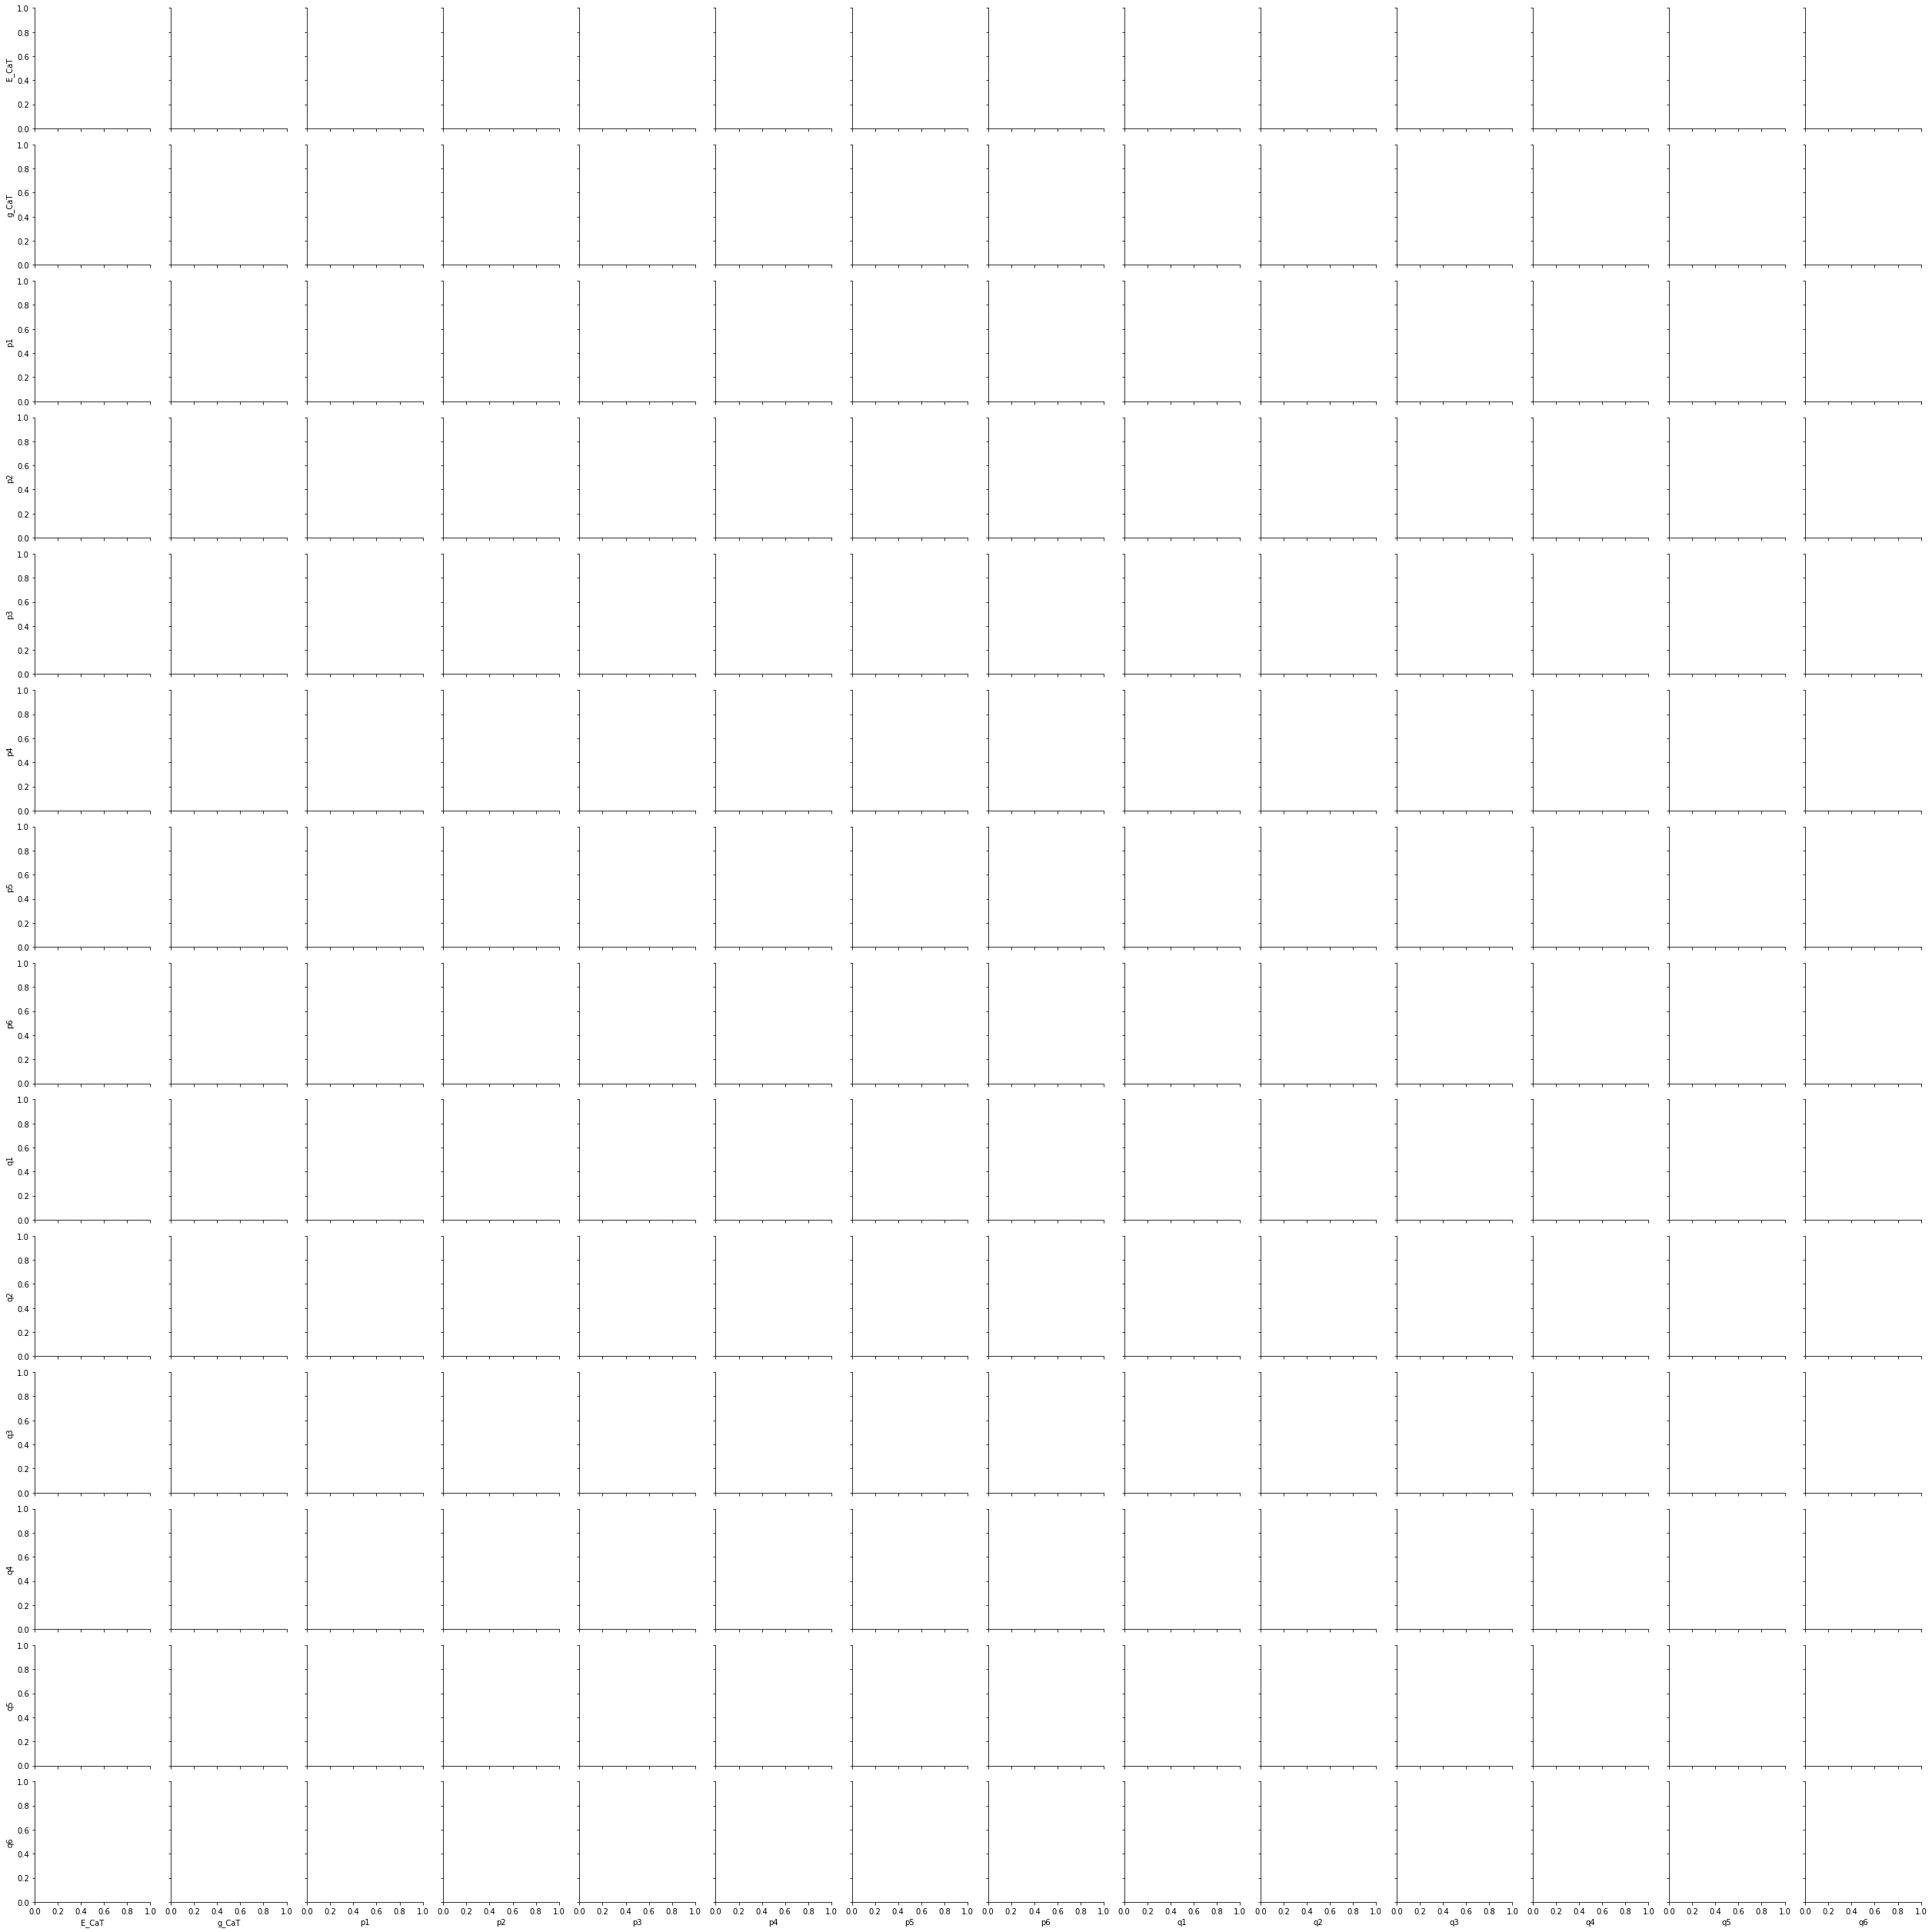

In [17]:
df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits, colorbar=False)

In [22]:
from pyabc_custom import simulate
samples = pd.DataFrame({})

post_df, post_w = history.get_distribution(m=0)
post_th = (post_df.sample(n=200,
                          weights=post_w,
                          replace=True)
           .to_dict(orient='records'))
for i, th in enumerate(post_th):
    output = simulate('icat', n_x=200, **th)
    #output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


In [33]:
def measured_plot(**kwargs):
    measurements = kwargs.pop('measurements')
    ax = plt.gca()
    data = kwargs.pop('data')
    exp = data['exp'].unique()[0]
    plt.errorbar(measurements.loc[measurements['exp']==exp]['x'],
                 measurements.loc[measurements['exp']==exp]['y'],
                 yerr=measurements.loc[measurements['exp']==exp]['errs'],
                 label='obs', ls='None', marker='x', color='k')

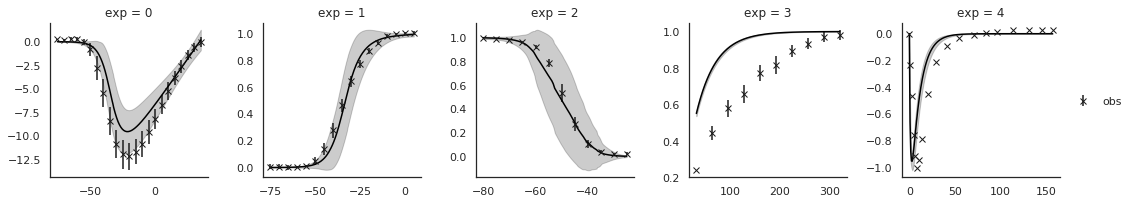

In [34]:
grid = sns.FacetGrid(samples,
                     col='exp', sharex='col', sharey='col',
                     legend_out=True)
grid = grid.map_dataframe(sns.lineplot, x='x', y='y',
                          estimator=np.mean,
                          err_style='band', ci='sd',
                          color='black')
grid = grid.map_dataframe(measured_plot, measurements=measurements).add_legend()

/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/scratch/cph211/miniconda3/envs/pyabc/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


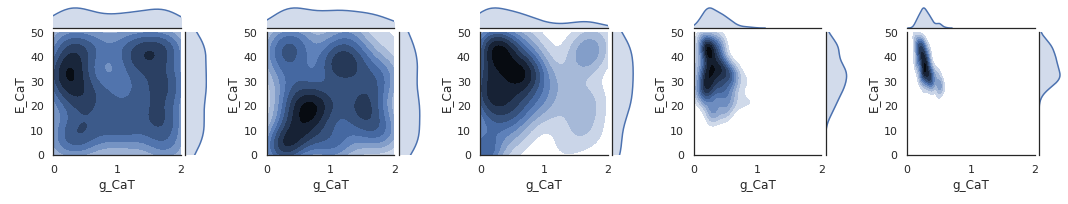

In [19]:
from visualization_custom import plot_kde_2d_custom
g = plot_kde_2d_custom(history, "g_CaT", "E_CaT", times=[0, 1, 5, 10, 19], limits=limits)

# Plotting sim results

In [5]:
history = History("sqlite:///pyabc-runs/hl-1_icat.db")

In [6]:
history.all_runs()

[<ABCSMC(id=1, start_time=2018-05-25 15:22:27.077816, end_time=None)>,
 <ABCSMC(id=2, start_time=2018-05-25 17:18:58.109548, end_time=None)>,
 <ABCSMC(id=3, start_time=2018-05-27 13:37:42.269082, end_time=2018-05-27 15:38:21.650434)>,
 <ABCSMC(id=4, start_time=2018-05-27 16:20:28.878427, end_time=2018-06-02 13:06:08.020335)>]

In [7]:
history.id = 4

In [8]:
n_samples = 500
post_df, post_w = history.get_distribution(m=0)
post_th = post_df.sample(n=n_samples, weights=post_w, replace=True).to_dict(orient='records')

/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


In [72]:
print(post_df.mean())
print(post_df.std())

name
E_CaT    28.607232
g_CaT     0.570818
p1       33.049958
p2        5.236290
p3        1.768542
p4        8.422280
p5        0.078802
p6       24.591353
q1       49.612638
q2        4.503643
q3        8.963260
q4       98.566606
q5        0.093050
q6       47.649166
dtype: float64
name
E_CaT    0.754076
g_CaT    0.072613
p1       0.880163
p2       0.244956
p3       0.178771
p4       1.067350
p5       0.019266
p6       5.744392
q1       0.665919
q2       0.494784
q3       0.796686
q4       1.099433
q5       0.004805
q6       2.520620
dtype: float64


In [9]:
from pyabc_custom import simulate

samples = pd.DataFrame({})
for i, th in log_progress(enumerate(post_th), every=1, size=len(post_th)):
    output = simulate('icat', n_x=210, **th)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

In [10]:
# Mean current density
print(np.mean(samples[samples.exp==0].groupby('sample').min()['y']))
# Std current density
print(np.std(samples[samples.exp==0].groupby('sample').min()['y']))

-15.217020620000001
1.4927236603679248


In [11]:
# Voltage of peak current density
idxs = samples[samples.exp==0].groupby('sample').idxmin()['y']
print(np.mean(samples.iloc[idxs]['x']))
print(np.std(samples.iloc[idxs]['x']))

-22.216842086
1.4575295021620545


In [12]:
# Half activation potential
def half_act(group):
    closest_to_half = min(group.y, key=lambda a: abs(a - 0.5))
    ind_x = group[group.y==closest_to_half].x.index[0]
    if closest_to_half > 0.5:
        other_side_ind_x = ind_x-1
    elif closest_to_half < 0.5:
        other_side_ind_x = ind_x+1
    else:
        return group[group.y==closest_to_half].x 
    # Linearly interpolate between two values
    x1 = group.loc[ind_x].x
    x2 = group.loc[other_side_ind_x].x
    y1 = group.loc[ind_x].y
    y2 = group.loc[other_side_ind_x].y    
    return x1 + (0.5-y1)*(x2-x1)/(y2-y1)

In [13]:
grouped = samples[samples.exp==1].groupby('sample')
print(np.mean(grouped.apply(half_act)))
print(np.std(grouped.apply(half_act)))

-33.58036568908192
1.4115989515325564


In [14]:
# Half activation potential
def half_inact(group):
    closest_to_half = min(group.y, key=lambda a: abs(a - 0.5))
    ind_x = group[group.y==closest_to_half].x.index[0]
    if closest_to_half > 0.5:
        other_side_ind_x = ind_x+1
    elif closest_to_half < 0.5:
        other_side_ind_x = ind_x-1
    else:
        return group[group.y==closest_to_half].x 
    # Linearly interpolate between two values
    x1 = group.loc[ind_x].x
    x2 = group.loc[other_side_ind_x].x
    y1 = group.loc[ind_x].y
    y2 = group.loc[other_side_ind_x].y    
    return x1 + (0.5-y1)*(x2-x1)/(y2-y1)

In [15]:
grouped = samples[samples.exp==2].groupby('sample')
print(np.mean(grouped.apply(half_inact)))
print(np.std(grouped.apply(half_inact)))

-49.534789689349594
0.7253296252390978


In [65]:
from scipy.optimize import curve_fit
def fit_single_exp(group):
    def single_exp(t, I_max, tau):
        return I_max*(1-np.exp(-t/tau))
    guess = (1, 50)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt[1]

In [66]:
grouped = samples[samples.exp==3].groupby('sample')
#grouped.apply(fit_single_exp)
print(grouped.apply(fit_single_exp))
print(np.mean(grouped.apply(fit_single_exp)))
print(np.std(grouped.apply(fit_single_exp)))

sample
0      41.118133
1      40.709856
2      41.797765
3      39.167625
4      40.805811
5      41.908676
6      39.212489
7      40.686454
8      39.689850
9      37.398595
10     41.947754
11     40.631016
12     38.998410
13     41.898446
14     40.811920
15     42.347701
16     41.886575
17     42.463118
18     41.513179
19     38.782576
20     42.081133
21     40.585852
22     42.264549
23     41.882760
24     38.638476
25     41.016255
26     41.565923
27     39.679388
28     41.279395
29     40.113595
         ...    
470    40.675554
471    40.555369
472    42.026688
473    40.356751
474    40.557076
475    40.431347
476    42.079881
477    40.787866
478    42.276591
479    41.101980
480    42.483660
481    41.508055
482    41.968781
483    41.698268
484    39.927622
485    41.244807
486    41.689067
487    41.209981
488    41.530537
489    41.992788
490    41.494645
491    40.757518
492    38.172408
493    41.177123
494    39.572926
495    40.632459
496    42.245054
497    

[ 1.00048989 42.34770136]


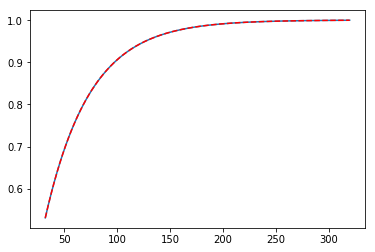

In [64]:
x = samples[(samples.exp==3) & (samples['sample']==15)].x
y = samples[(samples.exp==3) & (samples['sample']==15)].y
import matplotlib.pyplot as plt
plt.plot(x,y)
def single_exp(t, I_max, tau):
    return I_max*(1-np.exp(-t/tau))
guess = (1, 50)
popt, _ = curve_fit(single_exp, x, y, guess)
print(popt)
plt.plot(x, single_exp(x, *popt), '--r')

/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/scratch/cph211/miniconda3/envs/pyabc/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


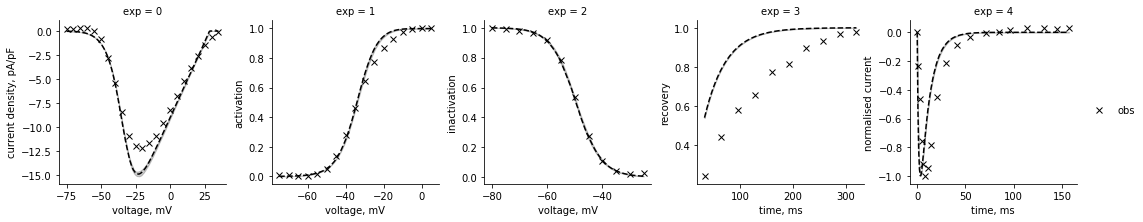

In [8]:
from visualization_custom import plot_sim_results
g = plot_sim_results(history, 'icat', n_samples=200, obs=measurements, n_x=200)
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms", "time, ms"]
ylabels = ["current density, pA/pF", "activation", "inactivation", "recovery", "normalised current"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
#plt.savefig('icat_results.pdf', format='pdf', dpi=1000)

In [ ]:
df, w = abc.history.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits, colorbar=False)

In [9]:
df, w = history.get_distribution(m=0)
df['wt'] = w
print("Mean")
for key in limits.keys():
    print(key, ":", sum(df[key] * df.wt))
print("Min")
for key in limits.keys():
    print(key, ":", min(df[key]))
print("Max")
for key in limits.keys():
    print(key, ":", max(df[key]))

Mean
g_CaT : 0.5744908621955785
E_CaT : 28.688434556455498
p1 : 33.02010315542557
p2 : 5.235044985417687
p3 : 1.739221978342799
p4 : 8.504914305936953
p5 : 0.07814348621785701
p6 : 24.05813303087214
q1 : 49.60948195877267
q2 : 4.478886531183562
q3 : 8.912086091428748
q4 : 98.5809348344708
q5 : 0.0929796738597656
q6 : 47.774480925643395
Min
g_CaT : 0.44240216918930636
E_CaT : 26.601785250960805
p1 : 30.103652652864373
p2 : 4.4227533244180055
p3 : 0.3121506832271061
p4 : 3.7475450416523706
p5 : 0.01019702339436698
p6 : 0.08305676051712929
q1 : 47.340789491988495
q2 : 2.9133251365855894
q3 : 5.419653056761908
q4 : 92.68667563732247
q5 : 0.07369100955334765
q6 : 41.01004391360781
Max
g_CaT : 0.9143096058728483
E_CaT : 31.820622967475625
p1 : 35.25846761133867
p2 : 6.017069200381783
p3 : 1.9998523874892515
p4 : 9.999608428079764
p5 : 0.09999949850367026
p6 : 38.853879597204006
q1 : 51.63890095944256
q2 : 6.0406551854576644
q3 : 9.99928485206019
q4 : 99.99991668823989
q5 : 0.0999972884734687

Initial run with reduced population to identify unconstrainable parameters.

In [ ]:
abc = ABCSMC(models=MyokitSimulation(),
             parameter_priors=prior,
             distance_function=distance,
             population_size=500,
             eps=MedianEpsilon(100, median_multiplier=1.0))
abc_id = abc.new(db_path, obs)

In [ ]:
history_init = abc.run(max_nr_populations=10, minimum_epsilon=0.01)

In [ ]:
from visualization_custom import plot_sim_results
plot_sim_results(history_init, "icat", n_samples=100, obs=measurements)

In [ ]:
df, w = history_init.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits)

In [ ]:
history_init = abc.run(max_nr_populations=20, minimum_epsilon=0.01)

In [ ]:
from visualization_custom import plot_sim_results
plot_sim_results(history_init, "icat", n_samples=100, obs=measurements)

In [ ]:
df, w = history_init.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits)

Reduce parameters varied and run with adaptive population size.

In [ ]:
abc = ABCSMC(models=MyokitSimulation(),
             parameter_priors=prior,
             distance_function=distance,
             population_size=AdaptivePopulationSize(
                 5000, 0.5, 
                 min_population_size=500,
                 max_population_size=10000),
            eps=MedianEpsilon(100, median_multiplier=1.0))
abc_id = abc.new(db_path, obs)

In [ ]:
history = abc.run(max_nr_populations=20, minimum_epsilon=0.5)